In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [3]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2020-09-20 16:59:27--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.167.128, 74.125.140.128, 173.194.76.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.167.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2020-09-20 16:59:27 (95.9 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



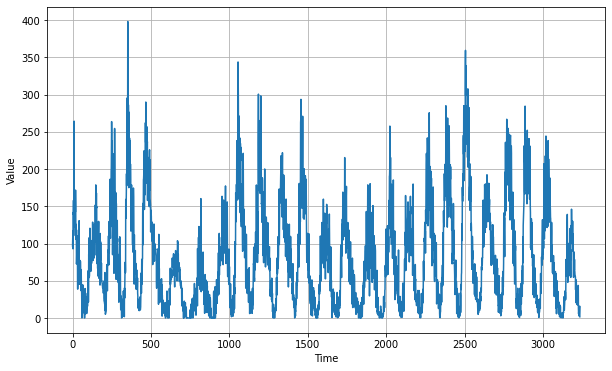

In [5]:
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

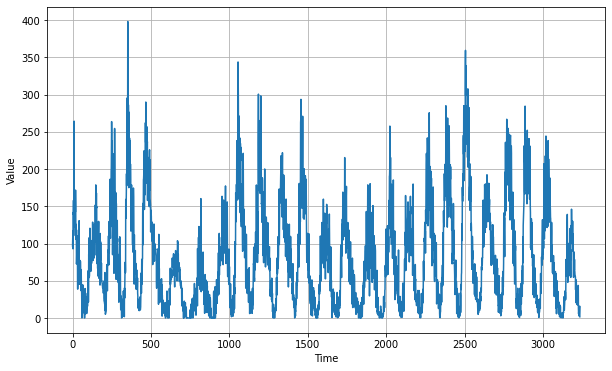

In [6]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [7]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [9]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 0s 40ms/step - loss: 79.8340 - mae: 80.3314
Epoch 2/100
12/12 [==============================] - 0s 41ms/step - loss: 78.0944 - mae: 78.5918
Epoch 3/100
12/12 [==============================] - 1s 44ms/step - loss: 75.4519 - mae: 75.9497
Epoch 4/100
12/12 [==============================] - 1s 44ms/step - loss: 72.2679 - mae: 72.7658
Epoch 5/100
12/12 [==============================] - 1s 45ms/step - loss: 68.7693 - mae: 69.2672
Epoch 6/100
12/12 [==============================] - 1s 45ms/step - loss: 65.1128 - mae: 65.6099
Epoch 7/100
12/12 [==============================] - 1s 45ms/step - loss: 61.5272 - mae: 62.0241
Epoch 8/100
12/12 [==============================] - 1s 47ms/step - loss: 58.1406 - mae: 58.6369
Epoch 9/100
12/12 [==============================] - 1s 48ms/step - loss: 55.0732 - mae: 55.5697
Epoch 10/100
12/12 [=====

(1e-08, 0.0001, 0.0, 60.0)

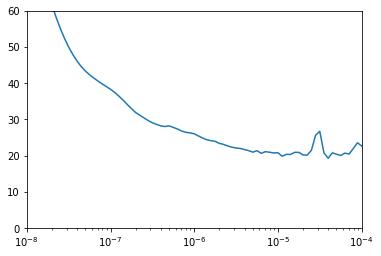

In [11]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [12]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 1s 21ms/step - loss: 38.9172 - mae: 39.4135
Epoch 2/500
30/30 [==============================] - 1s 23ms/step - loss: 25.7615 - mae: 26.2559
Epoch 3/500
30/30 [==============================] - 1s 23ms/step - loss: 22.0766 - mae: 22.5702
Epoch 4/500
30/30 [==============================] - 1s 23ms/step - loss: 20.4681 - mae: 20.9610
Epoch 5/500
30/30 [==============================] - 1s 23ms/step - loss: 19.7085 - mae: 20.2009
Epoch 6/500
30/30 [==============================] - 1s 23ms/step - loss: 19.2565 - mae: 19.7487
Epoch 7/500
30/30 [==============================] - 1s 24ms/step - loss: 18.6463 - mae: 19.1382
Epoch 8/500
30/30 [==============================] - 1s 23ms/step - loss: 18.2122 - mae: 18.7037
Epoch 9/500
30/30 [==============================] - 1s 23ms/step - loss: 18.1054 - mae: 18.5969
Epoch 10/500
30/30 [==============================] - 1s 24ms/step - loss: 20.0244 - mae: 20.5165
Epoch 11/500
30/30 [=========

In [13]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

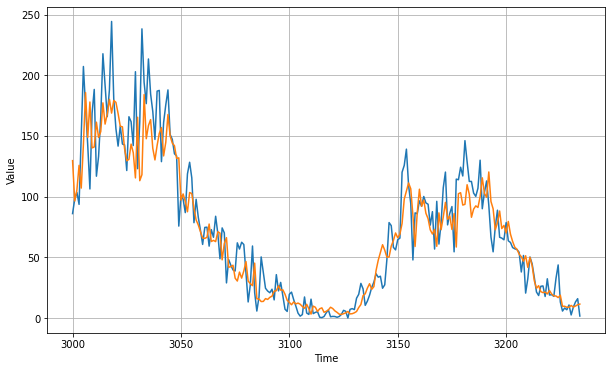

In [14]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [15]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

15.409984

<Figure size 432x288 with 0 Axes>

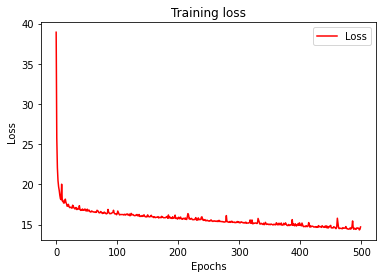

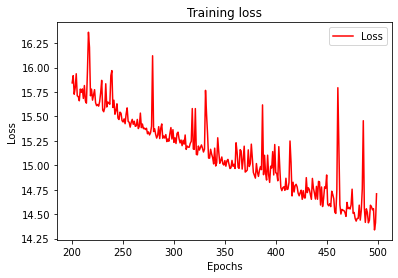

<Figure size 432x288 with 0 Axes>

In [16]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [17]:
print(rnn_forecast)

[129.626      96.379555  105.47712   125.74403   107.012665  142.89682
 185.70023   148.70287   177.94804   140.13286   140.9028    161.32466
 148.7236    153.54175   177.24702   159.73714   168.05156   180.16391
 168.79248   179.17581   177.65732   168.50436   158.02315   157.4768
 139.35246   129.47218   130.66034   143.2563    136.16435   115.38709
 165.39069   113.0965    118.071915  184.0344    147.67995   158.51581
 163.45177   139.8435    130.22308   142.09654   152.09901   156.87282
 133.52792   144.77238   167.65273   150.11844   144.07831   141.94
 131.51532   131.93784    97.13663   102.19625    95.978325   87.513985
 103.35138   102.52921    90.17094    80.76839    76.607315   71.01161
  65.90741    65.57025    66.43509    77.38688    63.01247    63.93992
  62.931156   70.99516    69.98488    47.888115   61.37854    66.16651
  41.79747    42.24175    43.469204   32.812164   30.437767   37.799778
  32.854717   38.750313   46.480774   30.38151    28.303183   26.63652
  45.204